In [1]:
import numpy as np
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_csv('../simulation_data/simulation_data.csv')
df_all.rename(columns={'median_PM10': 'PM10'}, inplace=True)

In [3]:
# none
df_0 = pd.concat([df_all[48:54], df_all[218:219], df_all[235:236], df_all[307:308], df_all[308:309], 
                  df_all[318:320]], ignore_index=True)
# first houses
df_1 = pd.concat([df_all[54:72], df_all[201:205], df_all[219:220], df_all[236:237], df_all[249:250], 
                  df_all[266:269], df_all[288:292], df_all[309:310], df_all[315:316]], ignore_index=True)
# park
df_2 = pd.concat([df_all[72:81], df_all[220:221], df_all[237:238], df_all[269:270], df_all[292:294], 
                  df_all[303:304], df_all[316:317], df_all[320:321], df_all[343:344]], ignore_index=True)
# water
df_3 = pd.concat([df_all[81:97], df_all[160:165], df_all[205:207], df_all[221:223], df_all[270:274], 
                  df_all[294:295], df_all[321:324]], ignore_index=True)
# road
df_4 = pd.concat([df_all[97:119], df_all[165:168], df_all[223:230], df_all[238:242], df_all[250:251], 
                  df_all[295:297], df_all[310:312], df_all[324:325], df_all[338:341]], ignore_index=True)
# second houses
df_5 = pd.concat([df_all[119:133], df_all[168:172], df_all[230:231], df_all[242:246], df_all[251:254], 
                  df_all[274:276], df_all[312:313], df_all[317:318], df_all[325:328], df_all[335:337], df_all[341:343]], ignore_index=True)
# train
df_6 = pd.concat([df_all[133:149], df_all[172:175], df_all[231:233], df_all[246:247], df_all[254:255], 
                  df_all[276:277], df_all[337:338]], ignore_index=True)
# parking lot
df_7 = pd.concat([df_all[149:160], df_all[175:184], df_all[233:234], df_all[247:248], df_all[255:256], 
                  df_all[277:278], df_all[297:301], df_all[344:345]], ignore_index=True)
# busy street
df_8 = pd.concat([df_all[:50], df_all[184:201], df_all[207:218], df_all[234:235], df_all[248:249], 
                  df_all[256:266], df_all[278:288], df_all[301:303], df_all[304:307], df_all[313:315], df_all[328:335], df_all[345:347]], ignore_index=True)

df = df_1
df = df.reset_index()
df['index'] = df.index # needed for folium choropleth mapping

In [4]:
attributes = ['PM2.5', 'PM10']
route_segments = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
descriptions = ['first houses', 'park', 'water', 'road', 'second houses', 'train', 'parking lot', 'busy street']

characteristics = ['track segment nr', 'description',
                   'minimum PM2.5', 'maximum PM2.5', 'mean PM2.5', 'median PM2.5',
                   'minimum PM10', 'maximum PM10', 'mean PM10', 'median PM10']
characteristics_data = []     

idx = 0
for segment_df in route_segments:
    characteristics_segments = []
    for attribute in attributes:
        minimum = segment_df[attribute].min()
        maximum = segment_df[attribute].max()
        median = segment_df[attribute].median()
        mean = segment_df[attribute].mean()
        characteristics_segments += [minimum, maximum, mean, median]
    characteristics_data.append([idx + 1, descriptions[idx]] + characteristics_segments)
    idx += 1

df_overview = pd.DataFrame(characteristics_data, columns = characteristics)
df_overview

,track segment nr,description,minimum PM2.5,maximum PM2.5,mean PM2.5,median PM2.5,minimum PM10,maximum PM10,mean PM10,median PM10
0,1,first houses,0.769710,19.042561,7.323523,6.811503,3.193334,17.719408,11.617723,12.542866
1,2,park,3.211585,33.650787,10.825888,7.815233,9.720460,32.719973,14.365056,12.472131
2,3,water,0.963812,18.532568,7.255782,5.969125,7.445915,20.360546,11.747866,11.304158
3,4,road,0.000000,30.614126,8.657051,5.703978,7.151845,28.430448,12.993087,11.647725
4,5,second houses,0.000000,30.526296,9.481745,7.195125,5.525041,34.327454,12.758901,11.822053
5,6,train,0.000000,21.304691,8.283184,6.291375,6.677823,21.224784,11.763490,11.302583
6,7,parking lot,0.000000,30.118665,8.269807,7.274594,7.868535,35.219583,13.519846,12.918874
7,8,busy street,0.445260,31.887323,8.902714,6.692185,7.434760,31.672384,14.246511,13.209928


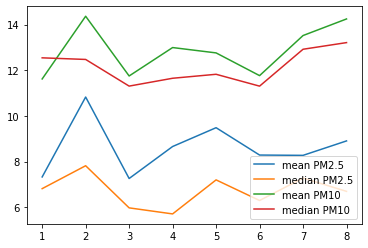

In [5]:
labels = ['mean PM2.5', 'median PM2.5', 'mean PM10', 'median PM10']
plt.plot(df_overview['track segment nr'], df_overview[labels])
plt.legend(labels)

In [6]:
# size of grid fields in °
step = 0.00015

# returns GeoJSON information of a single square
def get_square_json(index, lat, lon, step):
    return {
          "type": "Feature",
          "id": index,
          "properties": {
          },
          "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [lon, lat],
                [lon, lat + step],
                [lon + step, lat + step],
                [lon + step, lat],
                [lon, lat],
              ]]}}

# create json with all squares in grid
geo_json = "{\"type\":\"FeatureCollection\", \"features\": ["
for index, row in df.iterrows():
    if index != 0:
        geo_json += ','
    square_dict = get_square_json(index, row['latitude_index'], row['longitude_index'], step)
    geo_json += json.dumps(square_dict)
geo_json += "]}"

In [7]:
m = folium.Map(location=[df['latitude_index'][0], df['longitude_index'][0]], control_scale = True, zoom_start=16)

overlays = ['PM2.5', 'PM10']
featuregroups = np.empty(len(overlays), dtype=object)

#bins = [0, 5, 8, 10, 15, 20, 25, 30, 40]
bins = [0, 5, 9, 10, 11, 12, 13, 16, 18, 40]

choropleth_params = {'geo_data': geo_json,
                     'key_on': 'feature.id',
                     'fill_color': 'YlOrRd',
                     'nan_fill_color': 'White',
                     'fill_opacity': 0.7,
                     'line_opacity': 0.5,
                     'legend_name':'Mean PM2.5 in µg/m³ (of all data points in grid field)',
                     'bins': bins,
                     'highlight': True,
                     'reset': True
                    }

for idx, feature in enumerate(overlays):
    featuregroups[idx] = folium.FeatureGroup(name=overlays[idx],overlay=False).add_to(m)
    
    # make sure that data column does not contain nan values
    choropleth_data = df.dropna(subset=[feature]) 
    
    choropleth_params['data'] = choropleth_data
    choropleth_params['columns'] = ['index', feature]
    #bins_quantiles = list(df[feature].quantile([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]))
    #choropleth_params['bins'] = bins_quantiles
    
    choropleth = folium.Choropleth(**choropleth_params)
    choropleth.geojson.add_to(featuregroups[idx])

# add legend
legend = list(choropleth._children.values())[1]
legend.add_to(m)
    
#Add layer control to the map
folium.TileLayer('openstreetmap',overlay=True,name="View in openstreetmap").add_to(m)
folium.TileLayer('cartodbpositron',overlay=True,name="View in Light Mode", show=False).add_to(m)
folium.LayerControl(position='bottomright', collapsed=False).add_to(m)
m